In [105]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings("ignore")
import re
import re
import string
import nltk
from nltk.corpus import stopwords
from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
import nltk
from nltk.tokenize import word_tokenize,RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from platform import python_version
print (python_version())

3.7.6


In [2]:
os.chdir('D:\Datasets\Machine Learning\Text Mining\Python\Twitter disaster analysis')

In [3]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv("test.csv")

In [4]:
print(df_train.shape)
print(df_test.shape)

(7613, 5)
(3263, 4)


In [5]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
df_train.sample(10)

,id,keyword,location,text,target
6873,9854,trauma,"Chicago, Illinois",80 @UChicago faculty members pushing universit...,1
556,805,battle,USA,Black Eye 9: A space battle occurred at Star M...,1
205,290,ambulance,NaN,What's the police or ambulance number in Lesot...,0
3880,5518,flattened,"Bow, NH",IDEAS IN FOOD: Flattened http://t.co/QfrAWLn4BA,0
6206,8856,smoke,NaN,In 2014 I will only smoke crqck if I becyme a ...,0
3537,5059,eyewitness,"New York, NY",Freed #BokoHaram captives speak up: ÛÏI will ...,0
4662,6628,inundated,the Dirty D,@MI_Country_Hick pfft! I wish I had a bot like...,0
4979,7104,military,canada,Senator 'alarmed' by reports U.S. military fam...,1
6670,9559,thunder,"Enfield, UK",Illusoria Icarus nowplaying check out http://t...,0
3379,4840,evacuation,Northern California U.S.A.,Updated #RockyFire map with Mandatory Evacuati...,1


In [7]:
df_train.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [8]:
df_train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

([<matplotlib.axis.XTick at 0x166d65c6e88>,
 [Text(0, 0, 'Fake (No Disaster)'), Text(0, 0, 'Real (Disaster)')])

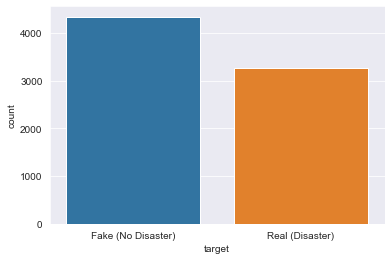

In [9]:
#Data visualization
sns.set_style('darkgrid')
sns.countplot(x = 'target', data = df_train)
Lables = ('Fake (No Disaster)', 'Real (Disaster)')
plt.xticks(range(2), Lables)

In [10]:
df_train[df_train['target']== 1]['keyword'].value_counts().head()

derailment     39
wreckage       39
outbreak       39
debris         37
oil%20spill    37
Name: keyword, dtype: int64

In [11]:
df_train[df_train['target']== 0]['keyword'].value_counts().head()

body%20bags    40
armageddon     37
harm           37
ruin           36
wrecked        36
Name: keyword, dtype: int64

In [12]:
#Let's see if the length of the tweets have any relation with the disaster. People tend to express their thoughts in the limited space of a tweet.
df_train['size'] = df_train['text'].apply(lambda x: len(x))

In [13]:
df_train.sample(5)

,id,keyword,location,text,target,size
3437,4913,exploded,?????? in Yokohama Japan,Kakeru Teduka: Bfore 70years of today in Hiros...,1,125
6083,8690,sinkhole,NaN,There's a sinkhole in Brooklyn ?!,1,33
1512,2183,catastrophic,Bouvet Island,@APANO55 @JamesMelville 99% of Scientists don...,1,118
1957,2819,cyclone,NaN,BBC Forced To Retract False Claims About Cyclo...,1,96
4436,6312,hostage,Global,The horrific story of being a hostage - The ho...,1,130


In [14]:
df_train['size'].describe()

count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: size, dtype: float64

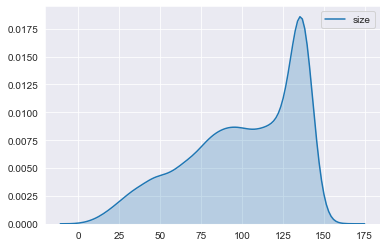

In [15]:
#Create distribution chart to visualize text length distribution
x = df_train['size']
sns.kdeplot(x, shade=True);

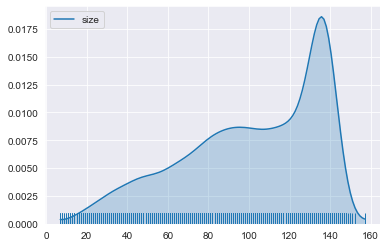

In [16]:
x = df_train['size']
sns.kdeplot(x, shade=True, cut=0)
sns.rugplot(x);

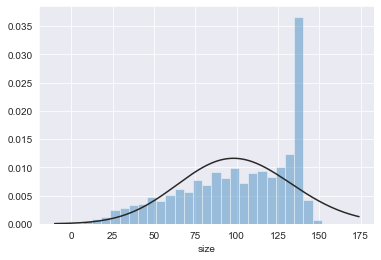

In [17]:
from scipy import stats
sns.distplot(x, kde=False, fit=stats.gamma);

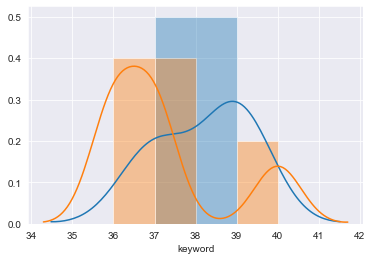

In [18]:
#creating a visualization of the distribution of text length in comparision to target feature
sns.distplot(df_train[df_train['target']== 1]['keyword'].value_counts().head())
sns.distplot(df_train[df_train['target']== 0]['keyword'].value_counts().head());

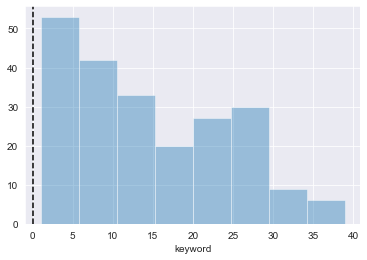

In [19]:
sns.distplot(df_train[df_train['target']== 1]['keyword'].value_counts(), kde=False);
plt.axvline(0, color="k", linestyle="--");

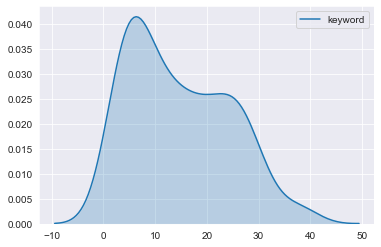

In [20]:
sns.kdeplot(df_train[df_train['target']== 1]['keyword'].value_counts(), shade=True)

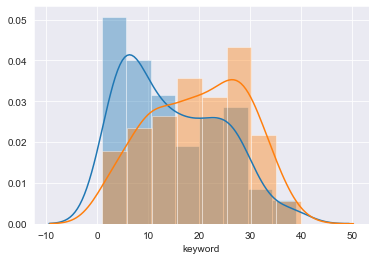

In [21]:
sns.distplot(df_train[df_train['target']== 1]['keyword'].value_counts())
sns.distplot(df_train[df_train['target']== 0]['keyword'].value_counts());

In [22]:
# Twitter length disrtibution

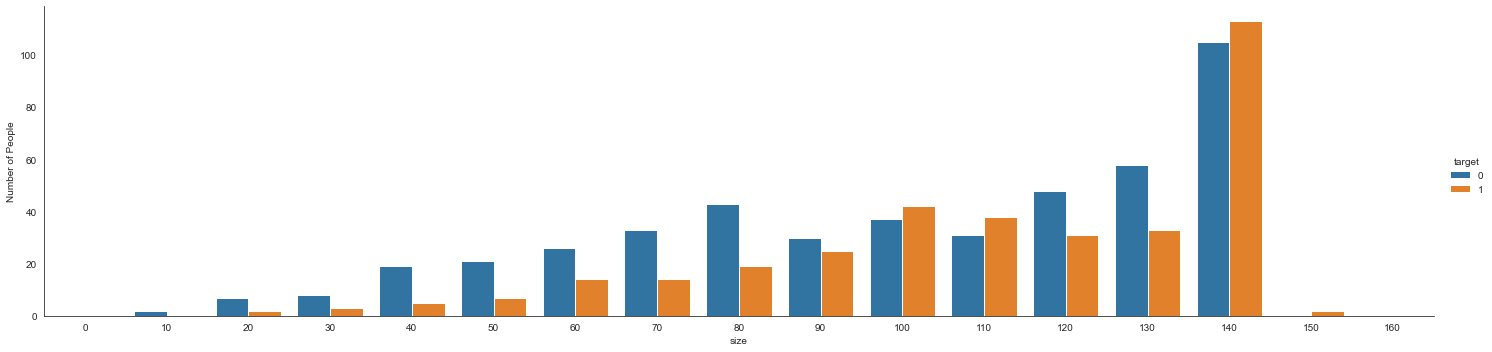

In [23]:

with sns.axes_style('white'):
    g = sns.factorplot("size", data=df_train, aspect=4.0, kind='count',
                       hue = "target", order=range(0, 165, 10))
    g.set_ylabels('Number of People')

Text(0.5, 1.0, 'Test Set')

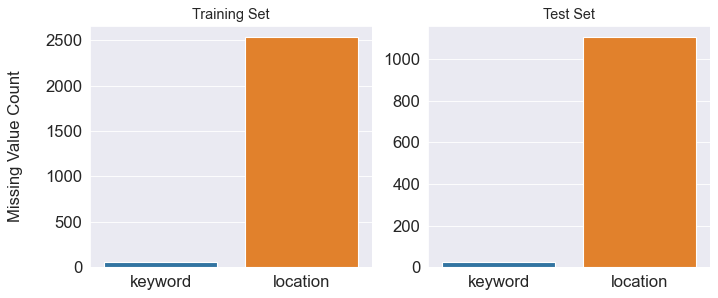

In [24]:
missing_cols = ['keyword', 'location']

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), dpi=80)

sns.barplot(x=df_train[missing_cols].isnull().sum().index, y=df_train[missing_cols].isnull().sum().values, ax=axes[0])
sns.barplot(x=df_test[missing_cols].isnull().sum().index, y=df_test[missing_cols].isnull().sum().values, ax=axes[1])

axes[0].set_ylabel('Missing Value Count', size=15, labelpad=20)
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

axes[0].set_title('Training Set', fontsize=13)
axes[1].set_title('Test Set', fontsize=13)

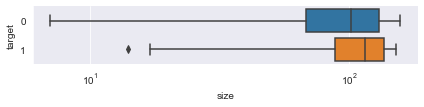

In [28]:
g = sns.catplot(x="size", y="target",
                kind="box", orient="h", height=1.5, aspect=4,
                data=df_train)
g.set(xscale="log");

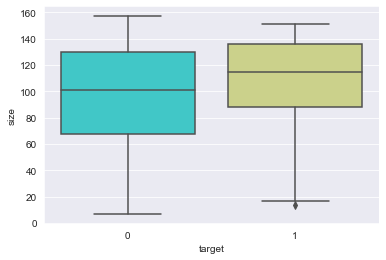

In [39]:
sns.boxplot(x = 'target', y = 'size', data = df_train, palette = "rainbow")

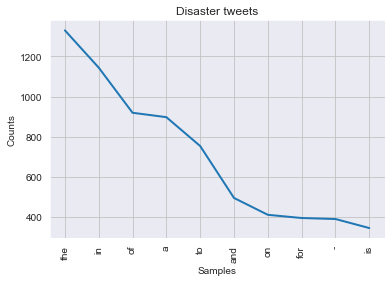

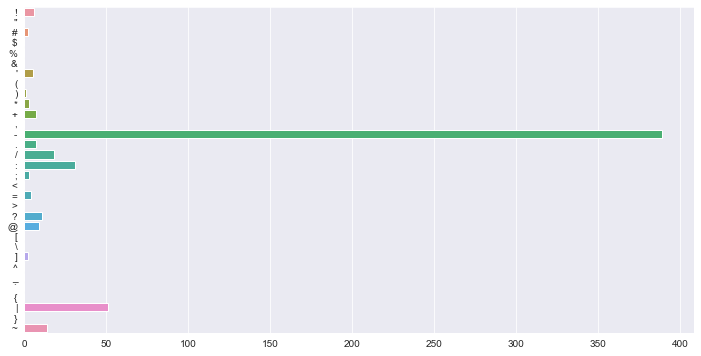

In [54]:
from nltk import FreqDist
from collections import defaultdict
from string import punctuation

text_disaster = df_train[df_train['target']==1]['text'].str.split()
text_Nodisaster = df_train[df_train['target']==0]['text'].str.split()

fdist = FreqDist(word.lower() for sentence in text_disaster for word in sentence)
fdist.plot(10, title="Disaster tweets")

dic=defaultdict(int)
punct = [fdist[p] for p in punctuation]
plt.figure(figsize=(12, 6))
sns.barplot(punct, list(punctuation))

# Data cleaning

In [55]:
import re
from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer

tokenizer = WordPunctTokenizer()
twitter_handle = r'@[A-Za-z0-9_]+'                         # remove twitter handle (@username)
url_handle = r'http[^ ]+'                                  # remove website URLs that start with 'https?://'
combined_handle = r'|'.join((twitter_handle, url_handle))  # join
www_handle = r'www.[^ ]+'                                  # remove website URLs that start with 'www.'
punctuation_handle = r'\W+'

In [56]:
stopwords = set(pd.read_csv("D:\Datasets\Machine Learning\Text Mining\Python\Twitter sentiment analysis self driving cars\stop-word-list.txt", sep = "\n", header = 0).stopword)

In [57]:
def process_data(text):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    try:
        text = souped.decode("utf=8-sig").replace(u"\ufffd", "?")
    except:
        text = souped
    cleaned_text = re.sub(punctuation_handle, " ",(re.sub(www_handle, '', re.sub(combined_handle, '', text)).lower()))
    cleaned_text = ' '.join([word for word in cleaned_text.split() if word not in stopwords])
    
    return (" ".join([word for word in tokenizer.tokenize(cleaned_text) if len(word) > 1])).strip()

In [117]:
# 2 Try
def cleaned_tweet(text):
    import re
    from nltk.corpus import stopwords
    from nltk.stem.porter import PorterStemmer
    tweets = re.sub("[^a-zA-Z]", ' ', text)
    tweets = tweets.lower()
    tweets = tweets.split()
    ps = PorterStemmer()
    tweets = [ps.stem(word) for word in tweets if not word in set(stopwords.words('english'))]
    tweets = ' '.join(tweets)
    return tweets

In [70]:
cleaned_text = []
for text in df_test.text:
    cleaned_text.append(process_data(text))

clean_text = pd.DataFrame({'clean_text':cleaned_text})
df_test = pd.concat([df_test, clean_text], axis = 1)

df_test.sample(5)

,id,keyword,location,text,clean_text
532,1742,buildings%20burning,NaN,kou is like [CASH REGISTER] [BUILDINGS BURNING],kou like cash register buildings burning
233,757,avalanche,Turin,Photo: #Repost @gregskazphotography with @repo...,photo repost åáåáåá avalanche ambi charging ha...
1818,6144,hijack,"FCT, Abuja",Tension In Bayelsa As Patience Jonathan Plans ...,tension bayelsa patience jonathan plans hijack...
632,2062,casualty,Canada | #LUX,@Rx_Casualty @Vpzedd @Daintt_M call,
899,2967,dead,NaN,???????? this the dead ass truth you pay for s...,dead ass truth pay shit gone use


In [71]:
cleaned_text = []
for text in df_train.text:
    cleaned_text.append(process_data(text))

clean_text = pd.DataFrame({'clean_text':cleaned_text})
df_train = pd.concat([df_train, clean_text], axis = 1)

df_train.sample(5)

,id,keyword,location,text,target,size,clean_text,clean_text
6556,9380,survived,Bulgaria,Cute &amp; all livin' the life then you zoom i...,0,131,cute livin life zoom face meme ready ve seen g...,cute livin life zoom face meme ready ve seen g...
7585,10839,NaN,NaN,Calgary Police Flood Road Closures in Calgary....,1,69,calgary police flood road closures calgary,calgary police flood road closures calgary
7334,10499,wildfire,"Ashland, Oregon",Be ember aware! http://t.co/LZmL1xB2nH,1,38,ember aware,ember aware
3140,4514,emergency,denmark,AlaskaÛªs Prince of Wales #ArchipelagoWolves ...,1,139,alaska ûªs prince wales archipelagowolves near...,alaska ûªs prince wales archipelagowolves near...
3138,4509,emergency,USA,Deals : http://t.co/ddhWoRI5w1 #37592 Temporar...,0,139,deals 37592 temporary fake tooth teeth replace...,deals 37592 temporary fake tooth teeth replace...


In [72]:
from collections import Counter 
raw_text = " ".join(df_train['text'])
hashtags = [w for w in raw_text.split() if w.startswith("#")]
hashtags = [w for w in hashtags if "driver" not in w.lower()]
Counter(hashtags).most_common(50)

[('#news', 36),
 ('#News', 36),
 ('#hot', 30),
 ('#prebreak', 30),
 ('#best', 30),
 ('#???', 23),
 ('#??', 20),
 ('#Hiroshima', 20),
 ('#GBBO', 16),
 ('#terrorism', 11),
 ('#ISIS', 11),
 ('#NowPlaying', 10),
 ('#nowplaying', 10),
 ('#India', 10),
 ('#Sismo', 10),
 ('#islam', 10),
 ('#RT', 9),
 ('#Directioners', 9),
 ('#Japan', 9),
 ('#jobs', 9),
 ('#CNN', 9),
 ('#yyc', 9),
 ('#BBC', 9),
 ('#earthquake', 8),
 ('#EDM', 8),
 ('#DnB', 8),
 ('#Beyhive', 8),
 ('#world', 8),
 ('#abstorm', 8),
 ('#Nursing', 8),
 ('#Islam', 8),
 ('#Dubstep', 7),
 ('#TrapMusic', 7),
 ('#Dance', 7),
 ('#Ices\x89Û_', 7),
 ('#', 7),
 ('#IranDeal', 7),
 ('#Earthquake', 7),
 ('#WX', 7),
 ('#animalrescue', 7),
 ('#Truth', 7),
 ('#god', 7),
 ('#Quran', 7),
 ('#Lies', 7),
 ('#US', 6),
 ('#MTVHottest', 6),
 ('#Handbag', 6),
 ('#Womens', 6),
 ('#\x89Û_', 6),
 ('#course', 6)]

In [73]:
#entity analysis Tells youtube most talked about

raw_text = " ".join(df_train['text'])
mentions = [w for w in raw_text.split() if w.startswith("@")]
Counter(mentions).most_common(50)

[('@YouTube', 82),
 ('@', 27),
 ('@ArianaGrande', 11),
 ('@POTUS', 9),
 ('@Change', 9),
 ('@FoxNews', 9),
 ('@emmerdale', 8),
 ('@djicemoon', 7),
 ('@justinbieber', 7),
 ('@MikeParrActor', 6),
 ('@Stretcher', 6),
 ('@Towel', 6),
 ('@usatoday', 5),
 ('@USAgov', 5),
 ('@YoungHeroesID', 5),
 ('@invalid', 5),
 ("@'aRmageddon", 4),
 ('@local_arsonist', 4),
 ('@LoneWolffur', 4),
 ('@Michael5SOS', 4),
 ('@Reuters', 4),
 ('@RaynbowAffair', 4),
 ('@DiamondKesawn', 4),
 ('@Grazed', 4),
 ('@Rexyy', 4),
 ('@ViralSpell', 3),
 ('@TrubGME', 3),
 ('@eBay', 3),
 ('@AP', 3),
 ('@USATODAY', 3),
 ('@Blizzard_draco', 3),
 ('@KurtSchlichter', 3),
 ('@po_st', 3),
 ('@Calum5SOS', 3),
 ('@nytimes', 3),
 ('@sharethis', 3),
 ('@guardian', 3),
 ('@ClaytonBryant', 3),
 ('@accionempresa', 3),
 ('@gerenciatodos', 3),
 ('@DavidVonderhaar', 3),
 ('@realDonaldTrump', 3),
 ('@unsuckdcmetro', 3),
 ('@YahooNews', 3),
 ('@TinyJecht', 3),
 ('@spinningbot', 3),
 ('@UN', 3),
 ('@smh', 3),
 ('@Refugees', 3),
 ('@TfLBusAlerts',

In [96]:
df_train.head(5)

,id,keyword,location,text,target,size,clean_text,clean_text,clean_tweet
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69,deeds reason earthquake allah forgive,deeds reason earthquake allah forgive,deed reason earthquak may allah forgiv us
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38,forest near la ronge sask canada,forest near la ronge sask canada,forest fire near la rong sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133,residents asked shelter place notified officer...,residents asked shelter place notified officer...,resid ask shelter place notifi offic evacu she...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65,13 000 people receive wildfires evacuation ord...,13 000 people receive wildfires evacuation ord...,peopl receiv wildfir evacu order california
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88,just got sent photo ruby alaska smoke wildfire...,just got sent photo ruby alaska smoke wildfire...,got sent photo rubi alaska smoke wildfir pour ...


In [97]:
df_test.head(5)

,id,keyword,location,text,clean_text,clean_tweet
0,0,NaN,NaN,Just happened a terrible car crash,just happened terrible car crash,happen terribl car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",heard earthquake different cities stay safe,heard earthquak differ citi stay safe everyon
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",forest spot pond geese fleeing street save,forest fire spot pond gees flee across street ...
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfires,apocalyps light spokan wildfir
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kills 28 china taiwan,typhoon soudelor kill china taiwan


In [107]:
# Vectorize the text using CountVectorizer
count_vectorizer = CountVectorizer()
train_cv = count_vectorizer.fit_transform(df_train['clean_tweet'])
test_cv = count_vectorizer.transform(df_test["clean_tweet"])

## Keeping only non-zero elements to preserve space 
print(train_cv[0].todense())

[[0 0 0 ... 0 0 0]]


In [108]:
#Split the CountVector vectorized data into train and test datasets for model training and testing
X_train_cv, X_test_cv, y_train_cv, y_test_cv =train_test_split(train_cv,df_train.target,test_size=0.2,random_state=2020)

In [109]:
#Define a function to fit and predict on training and test data sets
def fit_and_predict(model,X_train,y_train,X_test,y_test):
    
    # Fitting a simple Logistic Regression on Counts
    clf = model
    clf.fit(X_train, y_train)
    predictions=clf.predict(X_test)
    confusion_matrix(y_test,predictions)
    print(classification_report(y_test,predictions))
    print('-'*50)
    print("{}" .format(model))
    print('-'*50)
    print('Accuracy of classifier on training set:{}%'.format(round(clf.score(X_train, y_train)*100)))
    print('-'*50)
    print('Accuracy of classifier on test set:{}%' .format(round(accuracy_score(y_test,predictions)*100)))
    print('-'*50)

In [110]:
# Create a list of the regression models to be used
models=[LogisticRegression(C=1.0),SVC(),MultinomialNB(),DecisionTreeClassifier(),
        KNeighborsClassifier(n_neighbors=5),RandomForestClassifier()]

In [111]:
# Loop through the list of models and use 'fit_and_predict()' function to trian and make predictions
for model in models:
    fit_and_predict(model,X_train_cv, y_train_cv,X_test_cv,y_test_cv)

              precision    recall  f1-score   support

           0       0.79      0.89      0.84       849
           1       0.83      0.71      0.77       674

    accuracy                           0.81      1523
   macro avg       0.81      0.80      0.80      1523
weighted avg       0.81      0.81      0.81      1523

--------------------------------------------------
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
--------------------------------------------------
Accuracy of classifier on training set:97.0%
--------------------------------------------------
Accuracy of classifier on test set:81.0%
--------------------------------------------------
              precision    recall  f1-score   support

  

In [124]:
# Fitting 'LogisticRegression()' with CountVectorizer() fit dataset
clf_logreg = LogisticRegression(C=1.0)
clf_logreg.fit(X_train_cv, y_train_cv)
pred=clf_logreg.predict(X_test_cv)
confusion_matrix(y_test_cv,pred)
print(classification_report(y_test_cv,pred))
print('Accuracy of classifier on training set:{}%'.format(round(clf_logreg.score(X_train_cv, y_train_cv)*100)))
print('Accuracy of classifier on test set:{}%' .format(round(accuracy_score(y_test_cv,pred)*100)))

              precision    recall  f1-score   support

           0       0.79      0.89      0.84       849
           1       0.83      0.71      0.77       674

    accuracy                           0.81      1523
   macro avg       0.81      0.80      0.80      1523
weighted avg       0.81      0.81      0.81      1523

Accuracy of classifier on training set:97.0%
Accuracy of classifier on test set:81.0%


In [114]:
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
logreg= LogisticRegression()

# Define and fit grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=logreg, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train_cv, y_train_cv)

# Summarize and print results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.798139 using {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}


In [118]:
# Lets apply pre-processing function to clean and pre-process text data before vectorizing
test_df_final=df_test.copy()
test_df_final['text'] = test_df_final['text'].apply(lambda x : cleaned_tweet(x))

In [121]:
# Lets fit the test data with Countvectorizer() method to vectroize the data
test_vector = count_vectorizer.transform(test_df_final["text"])

In [131]:
# Define a function to generate predictions and store in a.csv file for submission on Kaggle
def submission(sub_file,model,test_vector):
    
    '''Input- sub_file=Location of the file submission file
              model=final fit model to be used for predictions
              test_vector=pre-processed and vectorized test dataset
       Output- submission file in .csv format with predictions       
    
    '''
    sub_df = pd.read_csv(sub_file)
    sub_df["target"] = model.predict(test_vector)
    sub_df.to_csv("submission.csv", index=False)

In [132]:
# Use Submission() function to generate submission file for posting on Kaggle
sub_file = "D:\Datasets\Machine Learning\Text Mining\Python\Twitter disaster analysis\sample_submission.csv"
test_vector=test_vector
submission(sub_file,clf_logreg,test_vector)